<a href="https://colab.research.google.com/github/badjie90/X-ray-Pneumonia-Classification-Using-DenseNet121-Transfer-Learning-State-of-art-Algorithm/blob/main/Pneumonia_Detection_and_Classification_Using_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this nootbook, I will used a DenseNet121 Transfer learning Model to train and classify Pneumonia in human chest X-ray images

In [1]:
import os
import random
import glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/X-ray_data

/content/drive/MyDrive/X-ray_data


### Fetching the data from the directory

In [4]:
train_path = "/content/drive/MyDrive/X-ray_data/chest_xray/train"
val_path = "/content/drive/MyDrive/X-ray_data/chest_xray/val"
test_path = "/content/drive/MyDrive/X-ray_data/chest_xray/test"

### Checking the number of images in the validation set. 

In [5]:
print(f"Normal X-Rays From Validation Set: {len(os.listdir(val_path + '/NORMAL'))} ")

print(f"Pneumonia X-Rays From Validation Set: {len(os.listdir(val_path + '/PNEUMONIA'))} ")

Normal X-Rays From Validation Set: 8 
Pneumonia X-Rays From Validation Set: 8 


### The Validation set contains 8 images in both normal and pneumonia folders and therefore, we need to split the training set and add it to the validation set to increase the number of images.

In [6]:
train_normal = pd.DataFrame({"path": os.listdir(train_path + "/NORMAL"), "label": "NORMAL"})
train_normal["path"] = train_normal["path"].apply(lambda x: train_path + "/NORMAL/" + x)
train_pneumonia = pd.DataFrame({"path": os.listdir(train_path + "/PNEUMONIA"), "label": "PNEUMONIA"})
train_pneumonia["path"] = train_pneumonia["path"].apply(lambda x: train_path + "/PNEUMONIA/" + x)

train_df = pd.concat([train_normal, train_pneumonia])

val_normal = pd.DataFrame({"path": os.listdir(val_path + "/NORMAL"), "label": "NORMAL"})
val_normal["path"] = val_normal["path"].apply(lambda x: val_path + "/NORMAL/" + x)
val_pneumonia = pd.DataFrame({"path": os.listdir(val_path + "/PNEUMONIA"), "label": "PNEUMONIA"})
val_pneumonia["path"] = val_pneumonia["path"].apply(lambda x: val_path + "/PNEUMONIA/" + x)

val_df = pd.concat([val_normal, val_pneumonia])

In [7]:
BATCH_SIZE = 32

SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)                      
random.seed(666)

In [8]:
train_data, val_data = train_test_split(train_df, 
                                        test_size = 0.1, 
                                        random_state = SEED, 
                                        stratify = train_df["label"], 
                                        shuffle = True)

val_data = pd.concat([val_df, val_data])

print(f"Training set size after re-splitting training data: {len(train_data)}")
print(f"Validation set size after re-splitting training data: {len(val_data)}")

Training set size after re-splitting training data: 4703
Validation set size after re-splitting training data: 539


4703

## Visualizing Sample X-Rays images

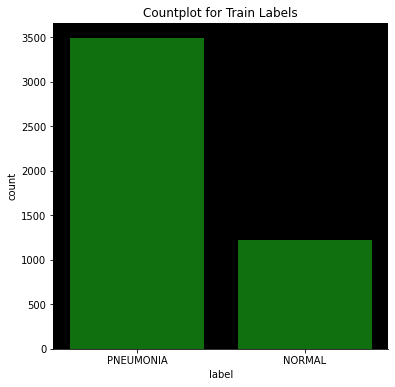

In [9]:
fig, ax = plt.subplots(figsize = (6, 6), facecolor = "white")
ax.set_facecolor("black")

sns.countplot(data = train_data, x = "label", ax = ax, color = "green")

ax.set_title("Countplot for Train Labels")

sns.despine()
plt.show()

#### Showing The Normal X-ray Images Samples

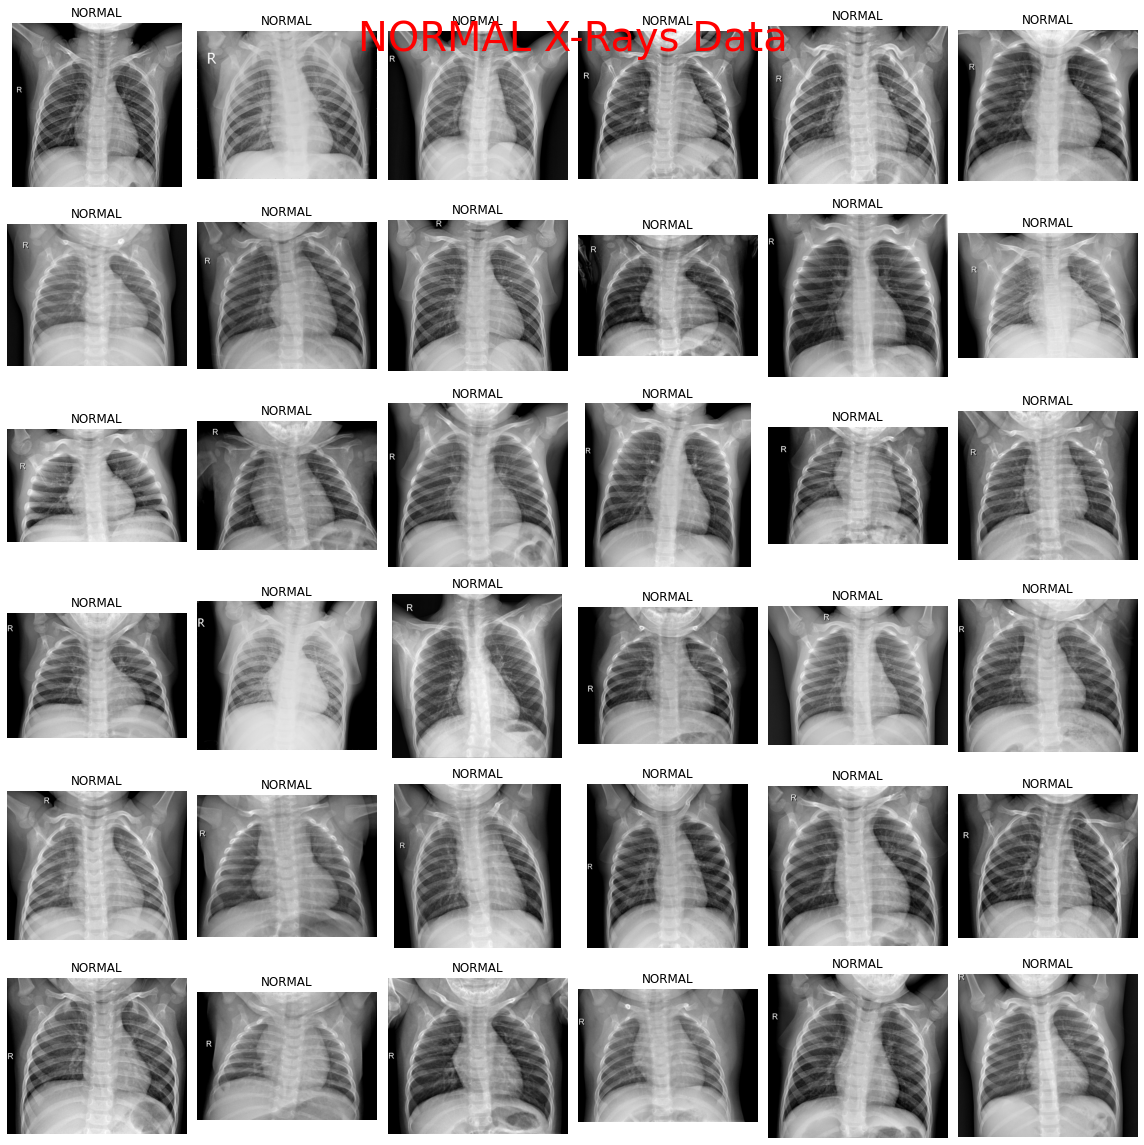

In [10]:
fig = plt.figure(1, figsize = (16, 16))
fig.suptitle("NORMAL X-Rays Data", color = 'red', fontsize = 40)

for i in range(36):
    
    ind = random.randint(0, len(train_data.query("label == 'NORMAL'")))

    plt.subplot(6, 6, i + 1)
    image = load_img(train_data.query("label == 'NORMAL'").reset_index()["path"][ind])
    plt.imshow(image)
    plt.title(train_data.query("label == 'NORMAL'").reset_index()["label"][ind])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

### Showing The Pneumonia X-ray Images Samples

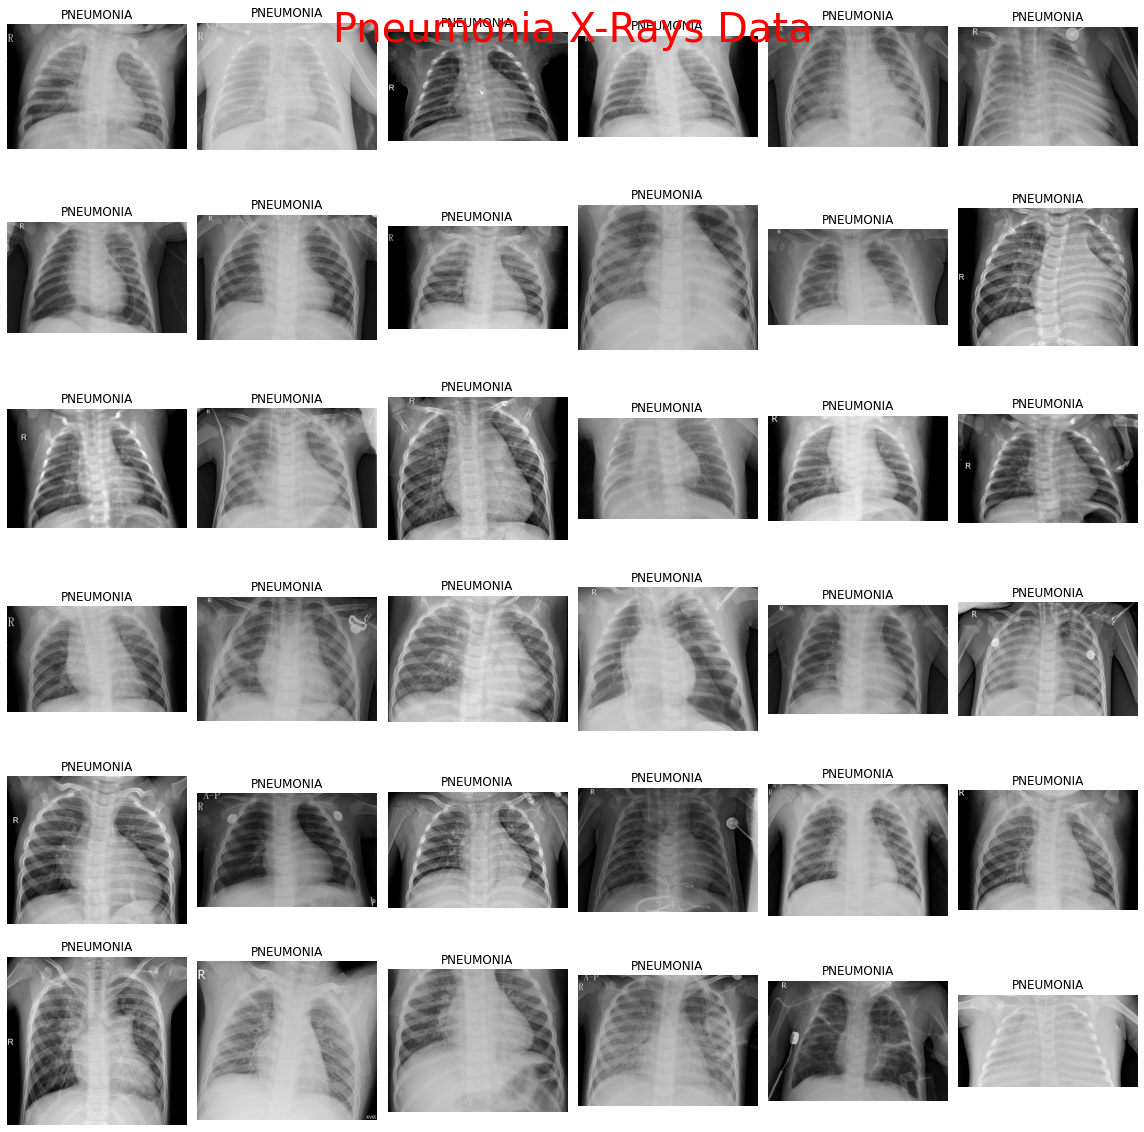

In [11]:
fig = plt.figure(1, figsize = (16, 16))
fig.suptitle("Pneumonia X-Rays Data", color = 'red', fontsize = 40)

for i in range(36):
    
    ind = random.randint(0, len(train_data.query("label == 'PNEUMONIA'")))

    plt.subplot(6, 6, i + 1)
    image = load_img(train_data.query("label == 'PNEUMONIA'").reset_index()["path"][ind])
    plt.imshow(image)
    plt.title(train_data.query("label == 'PNEUMONIA'").reset_index()["label"][ind])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

### Performing Data Augmentation to enable the model to improve on its generalization capability

Found 1 validated image filenames belonging to 1 classes.


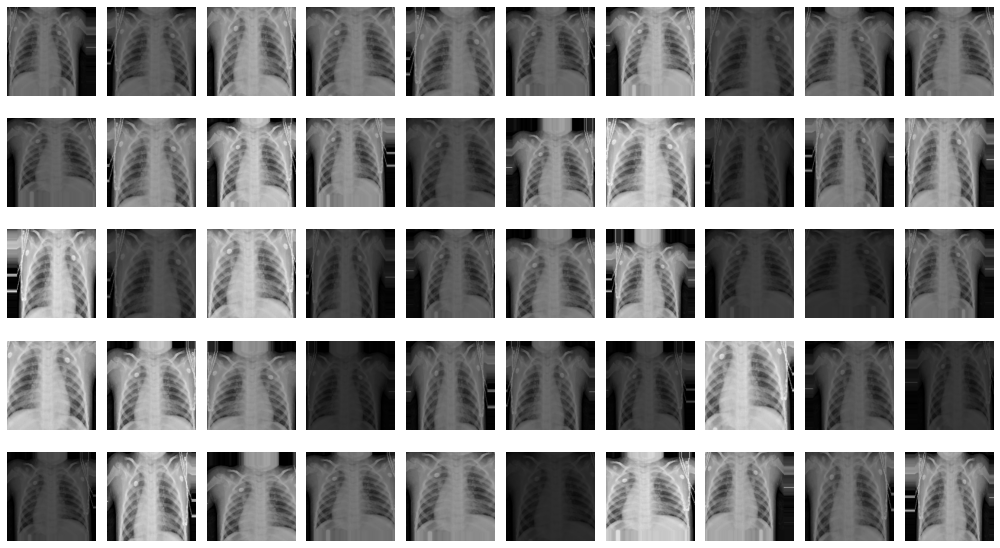

In [12]:
datagen = ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rescale = 1./255
)

sample_df = train_data.sample(1)

sample_generator = datagen.flow_from_dataframe(
    dataframe = sample_df,
    x_col = "path",
    y_col = "label",
    class_mode = "categorical",
    target_size = (150, 150),
    seed = 666
)

plt.figure(figsize = (14, 8))

for i in range(50):
    
    plt.subplot(5, 10, i + 1)
    
    for X, y in sample_generator:

        plt.imshow(X[0])
        plt.axis("off")
        break
        
plt.tight_layout()
plt.show()

#### Creating datagenerator for train, test and validation sets

In [13]:
train_datagen = ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = SEED
)

Found 4703 validated image filenames belonging to 2 classes.
Found 539 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Constructing the Transfer Learning Model

In [15]:
# Initializing the weights for the two classes
class_weights = compute_class_weight("balanced", classes = np.unique(train_data.label), y = train_data.label)

class_weights = {0: class_weights[0], 1: class_weights[1]}

In [16]:
base_model = DenseNet121(include_top = False, weights = "imagenet", input_shape = (150, 150, 3))

    
def dense121_pretrained():
    
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(128, activation = "relu"),
            Dropout(0.4),
            Dense(2, activation = "softmax")
        ]
    )
    
    return model

29097984/29084464 [==============================] - 0s 0us/step


In [17]:
tf.keras.backend.clear_session()

model = dense121_pretrained()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9,135,042
Trainable params: 9,051,394
Non-trainable params: 83,648
_________________________________________________________________


In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.0000001,
    cooldown = 1
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    verbose = 1,
    mode = "max",
    )

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "pneumonia_densenet121_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

history = model.fit(
    train_generator,
    epochs = 40, 
    batch_size = BATCH_SIZE,
    validation_data = val_generator,
     validation_steps = val_data.shape[0] // BATCH_SIZE,
    steps_per_epoch = train_data.shape[0] // BATCH_SIZE,
    callbacks = [reduce_lr, early_stopping, checkpoint],
    class_weight = class_weights
)

Epoch 1/40
146/146 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8677
Epoch 00001: val_accuracy improved from -inf to 0.92188, saving model to pneumonia_densenet121_.01-0.921875.hdf5
146/146 [==============================] - 1149s 8s/step - loss: 0.4254 - accuracy: 0.8677 - val_loss: 0.4489 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 2/40
146/146 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92188
146/146 [==============================] - 123s 841ms/step - loss: 0.1755 - accuracy: 0.9332 - val_loss: 0.5714 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 3/40
146/146 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9467
Epoch 00003: val_accuracy improved from 0.92188 to 0.95117, saving model to pneumonia_densenet121_.03-0.951172.hdf5
146/146 [==============================] - 123s 838ms/step - loss: 0.1463 - accuracy: 0.9467 - val_loss: 0.1152 - val_accuracy: 0.9512

### Plotting the Loss curve for train and validation losses

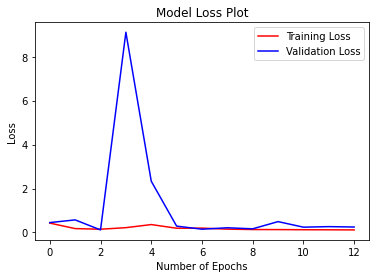

In [39]:
plt.plot(history.history['loss'], color = 'red', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.title('Model Loss Plot')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the accuracy curve for both the train and validation accuracies

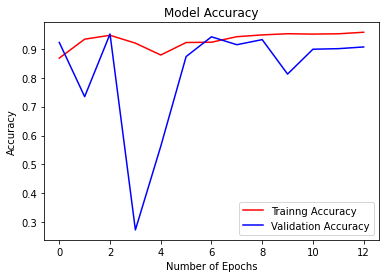

In [38]:
plt.plot(history.history['accuracy'], color = 'red', label = 'Trainng Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Checking the performance of the validation set

In [21]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = SEED
)

Found 539 validated image filenames belonging to 2 classes.


### Confusion Matrix for the validation set

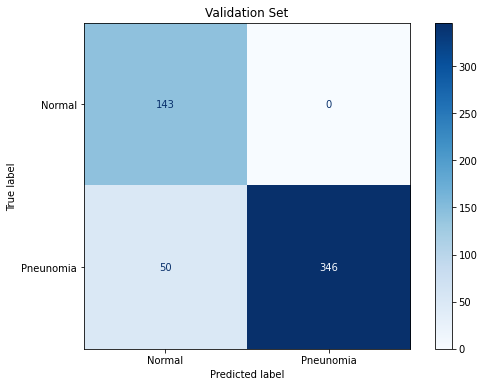

In [22]:
val_pred = model.predict(val_generator, steps = np.ceil(val_data.shape[0] / BATCH_SIZE))
val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis = 1)

labels = dict((v, k) for k, v in val_generator.class_indices.items())

val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)



fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal", "Pneunomia"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()

### Classification Report for the validation set

In [23]:
print(classification_report(val_data["label"], val_data["val_pred"]))

              precision    recall  f1-score   support

      NORMAL       0.74      1.00      0.85       143
   PNEUMONIA       1.00      0.87      0.93       396

    accuracy                           0.91       539
   macro avg       0.87      0.94      0.89       539
weighted avg       0.93      0.91      0.91       539



### Checking the Performance of the model on the test data

In [24]:
test_normal = pd.DataFrame({"path": os.listdir(test_path + "/NORMAL"), "label": "NORMAL"})
test_normal["path"] = test_normal["path"].apply(lambda x: test_path + "/NORMAL/" + x)
test_pneumonia = pd.DataFrame({"path": os.listdir(test_path + "/PNEUMONIA"), "label": "PNEUMONIA"})
test_pneumonia["path"] = test_pneumonia["path"].apply(lambda x: test_path + "/PNEUMONIA/" + x)

test_df = pd.concat([test_normal, test_pneumonia])

In [25]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = 1,
    shuffle = False,
    seed = SEED
)

Found 624 validated image filenames belonging to 2 classes.


### Confusion Matrix of the Test Set

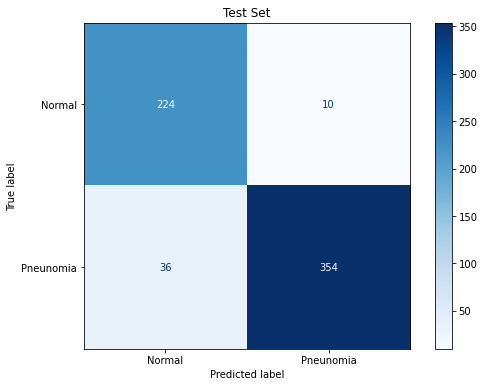

In [26]:
test_pred = model.predict(test_generator)
test_df.loc[:, "test_pred"] = np.argmax(test_pred, axis = 1)

labels = dict((v, k) for k, v in test_generator.class_indices.items())

test_df.loc[:, "test_pred"] = test_df.loc[:, "test_pred"].map(labels)


fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(test_df["label"], test_df["test_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal", "Pneunomia"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Test Set")
plt.show()

### Classification Report of the test Set

In [27]:
print(classification_report(test_df["label"], test_df["test_pred"]))

              precision    recall  f1-score   support

      NORMAL       0.86      0.96      0.91       234
   PNEUMONIA       0.97      0.91      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624



In [64]:
### Checking the Overall Accuracy of the model
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_df["label"], test_df["test_pred"])
print(f'The Accuracy score is: {accuracy*100:.2f}%')

The Accuracy score is: 92.63%


## Conclusion

For medical diagnosis, especially imbalanced dataset such as this dataset I am working with, accuracy is not always the best metric to determine the performance of a model. However, we need to give priority to precision, F1-score and recall as well as the confusion matrix. The true positive rate and the true negative rate can tell us more about the performance of the model. For this problem, recall is ratio of successfully detected pneumonia observations over all pneumonia observations.

Shortly, false negatives have bigger cost.

We have good score for both precision and recall. Our model for performs well.